#Imports

In [ ]:
!pip install unidecode
!pip install datasets
!pip install lz4
!pip install pathos
!pip install portalocker>=2.0.0

In [ ]:
import csv
import numpy as np
import math
import torch
import unidecode
from collections import defaultdict, OrderedDict, Counter
from torch.utils.data import DataLoader, Subset
from datasets import load_dataset
import gzip
import bz2
import lzma
import lz4.frame
import sys
from tqdm import tqdm
import torch.nn.functional as F
import io
import os
import torch
import numpy as np
import statistics
import operator
import random
from functools import partial
from itertools import repeat
from copy import deepcopy
from statistics import mode
import pickle
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial.distance import cosine
import scipy
import argparse
from pathos.multiprocessing import ProcessingPool as Pool
import time
from torchtext.datasets import IMDB, AG_NEWS, SogouNews, DBpedia, YelpReviewPolarity, YahooAnswers, AmazonReviewPolarity
import pandas as pd
from functools import reduce

# Helper Tools

In [ ]:
def read_fn_label(fn):
    text2label = {}
    with open(fn) as fo:
        reader = csv.reader(fo, delimiter=',', quotechar='"')
        for row in reader:
            label, title, desc = row[0], row[1], row[2]
            text = '. '.join([title, desc])
            text2label[text] = label
    return text2label

def read_label(fn):
    labels = []
    with open(fn) as fo:
        reader = csv.reader(fo, delimiter=',', quotechar='"')
        for row in reader:
            label, title, desc = row[0], row[1], row[2]
            labels.append(label)
    return labels

def read_fn_compress(fn):
    text = unidecode.unidecode(open(fn).read())
    text_list = text.strip().split('\n')
    return text_list

In [ ]:
class ToInt:
    def __call__(self, pic):
        return pic * 255

def NCD(c1, c2, c12):
    dis = (c12-min(c1,c2))/max(c1, c2)
    return dis

def CLM(c1, c2, c12):
    dis = 1 - (c1+c2-c12)/c12
    return dis

def CDM(c1, c2, c12):
    dis = c12/(c1+c2)
    return dis

def MSE(v1, v2):
    return np.sum((v1-v2)**2)/len(v1)

def agg_by_concat_space(t1, t2):
    return t1+' '+t2

def agg_by_jag_word(t1, t2, trunc=True):
    t1_list = t1.split(' ')
    t2_list = t2.split(' ')
    comb = []
    l = min([len(t1_list), len(t2_list)])
    for i in range(0,l-1,2):
        comb.append(t1_list[i])
        comb.append(t2_list[i+1])
    if len(t1_list) > len(t2_list):
        comb += t1_list[i:]
    return ' '.join(comb)

def agg_by_jag_char(t1, t2, trunc=True):
    t1_list = list(t1)
    t2_list = list(t2)
    comb = []
    l = min([len(t1_list), len(t2_list)])
    for i in range(0,l-1,2):
        comb.append(t1_list[i])
        comb.append(t2_list[i+1])
    if len(t1_list) > len(t2_list):
        comb += t1_list[i:]
    return ''.join(comb)

def agg_by_avg(i1, i2):
    return torch.div(i1+i2, 2, rounding_mode='trunc')

def agg_by_min_or_max(i1, i2, func_n):
    stacked = torch.stack([i1, i2], axis=0)
    if func_n == 'min':
        return torch.min(stacked, axis=0)[0]
    else:
        return torch.max(stacked, axis=0)[0]

def agg_by_stack(i1, i2):
    return torch.stack([i1, i2])

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# Data Processing Functions

In [ ]:
def pick_n_samples_from_each_class(dataset_name, dataset, n, output_fn, index_only=False):
    label2text = defaultdict(list)
    label2idx = defaultdict(list)
    class2count = {}

    # Collect texts and indices for each class
    for index, sample in enumerate(dataset):
        if dataset_name == 'ag_news':
            label = sample['label']
            text = sample['text']
            label2text[label].append(text)
            label2idx[label].append(index)
        elif dataset_name == 'sogou_news':
            label = sample['label']
            text = sample['title'] + ' ' + sample['content']
            label2text[label].append(text)
            label2idx[label].append(index)


    # Count the number of samples in each class
    for label in label2text:
        class2count[label] = len(label2text[label])

    selected_texts = []
    selected_labels = []
    selected_indices = []

    # Select n samples from each class
    for label, texts in label2text.items():
        if len(texts) >= n:
            selected_idx = np.random.choice(label2idx[label], n, replace=False)
        else:
            selected_idx = np.random.choice(label2idx[label], n, replace=True)

        # Convert numpy.int64 indices to Python int
        selected_idx = [int(i) for i in selected_idx]

        selected_texts.extend([label2text[label][label2idx[label].index(i)] for i in selected_idx])
        selected_labels.extend([label] * len(selected_idx))
        selected_indices.extend(selected_idx)

    # Save indices to a file if output filename is provided
    if output_fn is not None:
        np.save(output_fn, np.array(selected_indices))

    if index_only:
        return np.array(selected_indices), selected_labels

    return selected_texts, selected_labels


# Compressor Functions

In [ ]:
class DefaultCompressor:
    """for non-neural-based compressor"""
    def __init__(self, compressor, typ='text'):
        if compressor == 'gzip':
            self.compressor = gzip
        elif compressor == "lz4":
            self.compressor = lz4.frame
        else:
            raise RuntimeError("Unsupported compressor")
        self.type = typ
    def get_compressed_len(self, x):
        if self.type == 'text':
            return len(self.compressor.compress(x.encode('utf-8')))
        else:
            return len(self.compressor.compress(np.array(x).tobytes()))
    def get_bits_per_char(self, original_fn):
        with open(original_fn) as fo:
            data = fo.read()
            compressed_str = self.compressor.compress(data.encode('utf-8'))
            return len(compressed_str)*8/len(data)

In [ ]:
class KnnExpText:
    def __init__(self, agg_f, comp, dis):
        self.aggregation_func = agg_f
        self.compressor = comp
        self.distance_func = dis
        self.dis_matrix = []

    def calc_dis(self, data, train_data=None, fast=False):
        if train_data is not None:
            data_to_compare = train_data
        else:
            data_to_compare = data
        for i, t1 in enumerate(data):
            distance4i = []
            if fast:
                t1_compressed = self.compressor.get_compressed_len_fast(t1)
            else:
                t1_compressed = self.compressor.get_compressed_len(t1)
            for j, t2 in enumerate(data_to_compare):
                if fast:
                    t2_compressed = self.compressor.get_compressed_len_fast(t2)
                    t1t2_compressed = self.compressor.get_compressed_len_fast(self.aggregation_func(t1,t2))
                else:
                    t2_compressed = self.compressor.get_compressed_len(t2)
                    t1t2_compressed = self.compressor.get_compressed_len(self.aggregation_func(t1, t2))
                distance = self.distance_func(t1_compressed, t2_compressed, t1t2_compressed)
                distance4i.append(distance)
            self.dis_matrix.append(distance4i)

    def calc_dis_with_single_compressed_given(self, data, data_len=None, train_data=None):
        if train_data is not None:
            data_to_compare = train_data
        else:
            data_to_compare = data
        for i, t1 in enumerate(data):
            distance4i = []
            t1_compressed = self.compressor.get_compressed_len_given_prob(t1, data_len[i])
            for j, t2 in enumerate(data_to_compare):
                t2_compressed = self.compressor.get_compressed_len_given_prob(t2, data_len[j])
                t1t2_compressed = self.compressor.get_compressed_len(self.aggregation_func(t1, t2))
                distance = self.distance_func(t1_compressed, t2_compressed, t1t2_compressed)
                distance4i.append(distance)
            self.dis_matrix.append(distance4i)

    def calc_dis_single(self, t1, t2):
        t1_compressed = self.compressor.get_compressed_len(t1)
        t2_compressed = self.compressor.get_compressed_len(t2)
        t1t2_compressed = self.compressor.get_compressed_len(self.aggregation_func(t1, t2))
        distance = self.distance_func(t1_compressed, t2_compressed, t1t2_compressed)
        return distance

    def calc_dis_single_multi(self, train_data, datum):
        distance4i = []
        t1_compressed = self.compressor.get_compressed_len(datum)
        for j, t2 in enumerate(train_data):
            t2_compressed = self.compressor.get_compressed_len(t2)
            t1t2_compressed = self.compressor.get_compressed_len(self.aggregation_func(datum, t2))
            distance = self.distance_func(t1_compressed, t2_compressed, t1t2_compressed)
            distance4i.append(distance)
        return distance4i

    def calc_dis_with_vector(self, data, train_data=None):
        if train_data is not None:
            data_to_compare = train_data
        else:
            data_to_compare = data
        for i, t1 in enumerate(data):
            distance4i = []
            for j, t2 in enumerate(data_to_compare):
                distance = self.distance_func(t1, t2)
                distance4i.append(distance)
            self.dis_matrix.append(distance4i)

    def calc_acc(self, k, label, train_label=None, provided_distance_matrix=None, rand=False):
        if provided_distance_matrix is not None:
            self.dis_matrix = provided_distance_matrix
        correct = []
        pred = []
        if train_label is not None:
            compare_label = train_label
            start = 0
            end = k
        else:
            compare_label = label
            start = 1
            end = k+1
        for i in range(len(self.dis_matrix)):
            sorted_idx = np.argsort(np.array(self.dis_matrix[i]))
            pred_labels = defaultdict(int)
            for j in range(start, end):
                pred_l = compare_label[sorted_idx[j]]
                pred_labels[pred_l] += 1
            sorted_pred_lab = sorted(pred_labels.items(), key=operator.itemgetter(1), reverse=True)
            most_count = sorted_pred_lab[0][1]
            if_right = 0
            most_label = sorted_pred_lab[0][0]
            most_voted_labels = []
            for pair in sorted_pred_lab:
                if pair[1] < most_count:
                    break
                if not rand:
                    if pair[0] == label[i]:
                        if_right = 1
                        most_label = pair[0]
                else:
                    most_voted_labels.append(pair[0])
            if rand:
                most_label = random.choice(most_voted_labels)
                if_right = 1 if most_label==label[i] else 0
            pred.append(most_label)
            correct.append(if_right)

        accuracy = sum(correct)/len(correct)
        return accuracy

    def combine_dis_acc(self, k, data, label, train_data=None, train_label=None):
        correct = []
        pred = []
        if train_label is not None:
            compare_label = train_label
            start = 0
            end = k
        else:
            compare_label = label
            start = 1
            end = k+1
        if train_data is not None:
            data_to_compare = train_data
        else:
            data_to_compare = data
        for i, t1 in enumerate(data):
            distance4i = self.calc_dis_single_multi(data_to_compare, t1)
            sorted_idx = np.argsort(np.array(distance4i))
            pred_labels = defaultdict(int)
            for j in range(start, end):
                pred_l = compare_label[sorted_idx[j]]
                pred_labels[pred_l] += 1
            sorted_pred_lab = sorted(pred_labels.items(), key=operator.itemgetter(1), reverse=True)
            most_count = sorted_pred_lab[0][1]
            if_right = 0
            most_label = sorted_pred_lab[0][0]
            for pair in sorted_pred_lab:
                if pair[1] < most_count:
                    break
                if pair[0] == label[i]:
                    if_right = 1
                    most_label = pair[0]
            pred.append(most_label)
            correct.append(if_right)
        print("Accuracy is {}".format(sum(correct) / len(correct)))
        return pred, correct

    def combine_dis_acc_single(self, k, train_data, train_label, datum, label):
        # Support multi processing - must provide train data and train label
        distance4i = self.calc_dis_single_multi(train_data, datum)
        sorted_idx = np.argpartition(np.array(distance4i), range(k))
        pred_labels = defaultdict(int)
        for j in range(k):
            pred_l = train_label[sorted_idx[j]]
            pred_labels[pred_l] += 1
        sorted_pred_lab = sorted(pred_labels.items(), key=operator.itemgetter(1), reverse=True)
        most_count = sorted_pred_lab[0][1]
        if_right = 0
        most_label = sorted_pred_lab[0][0]
        for pair in sorted_pred_lab:
            if pair[1] < most_count:
                break
            if pair[0] == label:
                if_right = 1
                most_label = pair[0]
        pred=most_label
        correct=if_right
        return pred, correct


In [ ]:
def ngram_hash_comparison(test_data, test_label, train_data, train_label):
    """Will be called when compressor == "hashed_ngrams"."""
    def custom_hash(ngram, n_integers=10e8):
        """Hashs to n-integer hash code."""
        return hash(ngram) % int(n_integers)

    def to_ngrams(text, min_ngram=5, max_ngram=50):
        """Converts the data to a set of its hashed n-grams."""
        return {
            custom_hash(text[i:i+n])
            for n in range(min_ngram, max_ngram)
            for i in range(len(text)-n+1)
        }

    def to_df(data, label):
        return pd.DataFrame(
            {
                "data": data,
                "label": label,
            }
        )

    def union_all(series):
        return reduce(lambda x, y: x.union(y), series)

    start = time.time()

    # Construct training set
    train_df = to_df(train_data, train_label)
    hashed = train_df["data"].apply(to_ngrams)
    class_groups = hashed.groupby(train_df["label"]).agg(union_all)

    # Construct test set
    test_df = to_df(test_data, test_label)
    test_ngrams = test_df["data"].apply(to_ngrams)

    prediction = test_ngrams.apply(
        lambda x: pd.Series(
            [len(x.intersection(class_ngram_set)) for _, class_ngram_set in class_groups.items()],
            index=class_groups.index
        ).idxmax()
    )

    # Report performance
    accuracy = (prediction == test_df["label"]).mean()
    time_spent = time.time() - start

    return accuracy, time_spent



def non_neural_knn_exp(compressor_name, test_data, test_label, train_data, train_label, agg_func, dis_func, k, para=True):
    accuracy = None
    cp = DefaultCompressor(compressor_name)
    knn_exp_ins = KnnExpText(agg_func, cp, dis_func)
    start = time.time()
    if para:
        with Pool(2) as p:
            pred_correct_pair = p.map(partial(knn_exp_ins.combine_dis_acc_single, k, train_data, train_label), test_data, test_label)
        # print('accuracy:{}'.format(np.average(np.array(pred_correct_pair, dtype=np.int32)[:,1])))
        accuracy = np.average(np.array(pred_correct_pair, dtype=np.int32)[:,1])
    else:
        knn_exp_ins.calc_dis(test_data, train_data=train_data)
        accuracy = knn_exp_ins.calc_acc(k, test_label, train_label=train_label)

    time_spent = time.time() - start

    return accuracy, time_spent

def record_distance(compressor_name, test_data, test_portion_name, train_data, agg_func, dis_func, out_dir, para=True):
    # print("compressor={}".format(compressor_name))
    numpy_dir = os.path.join(out_dir, compressor_name)
    if not os.path.exists(numpy_dir):
        os.makedirs(numpy_dir)
    out_fn = os.path.join(numpy_dir, test_portion_name)
    cp = DefaultCompressor(compressor_name)
    knn_exp = KnnExpText(agg_func, cp, dis_func)
    start = time.time()
    if para:
        with Pool(2) as p:
            distance_for_selected_test = p.map(partial(knn_exp.calc_dis_single_multi, train_data), test_data)
        np.save(out_fn, np.array(distance_for_selected_test))
        del distance_for_selected_test
    else:
        knn_exp.calc_dis(test_data, train_data=train_data)
        np.save(out_fn, np.array(knn_exp.dis_matrix))
    # print("spent: {}".format(time.time() - start))


def non_neurl_knn_exp_given_dis(dis_matrix, k, test_label, train_label):
    knn_exp = KnnExpText(None, None, None)
    _, correct = knn_exp.calc_acc(k, test_label, train_label=train_label, provided_distance_matrix=dis_matrix)
    return correct

#Experiments

In [ ]:
data_dir = 'data'
output_dir = 'text_exp_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k = 2
para = True

# Datasets and compressors to iterate over
datasets = ['ag_news', 'sogou_news']
compressors = ['gzip', 'lz4', 'hashed_ngram']
num_trains = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

# DataFrame to store results
results = []

# Loop over configurations
for dataset in datasets:

    if dataset == 'ag_news':
      num_test  = 1500
    elif dataset == 'sogou_news':
      num_test = 750
    train_idx_fn = os.path.join(output_dir, '{}_train_indicies'.format(dataset))
    test_idx_fn = os.path.join(output_dir, '{}_test_indicies'.format(dataset))

    # Load dataset
    full_dataset = load_dataset(dataset)
    train_dataset = full_dataset['train']
    test_dataset = full_dataset['test']
    test_data, test_labels = pick_n_samples_from_each_class(dataset,test_dataset, num_test, test_idx_fn)

    for compressor in compressors:
        for num_train in num_trains:
            accuracies = []
            time_spents = []

            # adjust seeds to decrease the std
            if num_train < 25:
              seeds = [1, 2, 3, 4, 5]
            elif num_train < 75:
              seeds = [1,2,3]
            else:
              seeds = [1]

            for seed in seeds:
                np.random.seed(seed)
                train_data, train_labels = pick_n_samples_from_each_class(dataset,train_dataset, num_train, train_idx_fn)

                if compressor == "hashed_ngram":
                    acc, time_spent = ngram_hash_comparison(test_data, test_labels, train_data, train_labels)
                else:
                    acc, time_spent = non_neural_knn_exp(compressor, test_data, test_labels, train_data, train_labels, agg_by_concat_space, NCD, k, para=para)

                accuracies.append(acc)
                time_spents.append(time_spent)

                # Print current configuration and accuracy
                print(f"Dataset: {dataset}, Compressor: {compressor}, Number of Training Samples: {num_train}, Seed: {seed}, Accuracy: {acc:.2f}, Time Spent: {time_spent:.2f}")

            # Calculate average accuracy
            avg_acc = np.mean(accuracies)
            avg_time_spent = np.mean(time_spents)
            results.append([dataset, compressor, num_train, avg_acc, avg_time_spent])
        print('Compressor: {compressor} results:')
        print(results)

# Convert results to DataFrame
df = pd.DataFrame(results, columns=['dataset', 'compressor', 'n_shots', 'avg_acc', 'avg_time_spent'])



Dataset: ag_news, Compressor: gzip, Number of Training Samples: 5, Seed: 1, Accuracy: 0.57, Time Spent: 14.51
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 5, Seed: 2, Accuracy: 0.59, Time Spent: 12.28
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 5, Seed: 3, Accuracy: 0.60, Time Spent: 14.16
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 10, Seed: 1, Accuracy: 0.59, Time Spent: 22.32
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 10, Seed: 2, Accuracy: 0.61, Time Spent: 23.45
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 10, Seed: 3, Accuracy: 0.62, Time Spent: 25.43
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 25, Seed: 1, Accuracy: 0.64, Time Spent: 55.05
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 25, Seed: 2, Accuracy: 0.65, Time Spent: 55.59
Dataset: ag_news, Compressor: gzip, Number of Training Samples: 25, Seed: 3, Accuracy: 0.63, Time Spent: 54.72
Data

NameError: ignored

In [ ]:
results = [['ag_news', 'gzip', 5, 0.5878888888888888, 13.649047136306763],
 ['ag_news', 'gzip', 10, 0.6063333333333333, 23.733816226323444],
 ['ag_news', 'gzip', 25, 0.641, 55.12038787206014],
 ['ag_news', 'gzip', 50, 0.6829444444444445, 109.87722269694011],
 ['ag_news', 'gzip', 75, 0.7009444444444445, 160.89457043011984],
 ['ag_news', 'gzip', 100, 0.7244444444444444, 208.07464051246643],
 ['ag_news', 'gzip', 125, 0.7439444444444444, 258.8982038497925],
 ['ag_news', 'gzip', 150, 0.7592222222222222, 311.76334381103516],
 ['ag_news', 'gzip', 175, 0.7692777777777778, 364.8796519438426],
 ['ag_news', 'gzip', 200, 0.7740555555555555, 411.74796652793884],
 ['ag_news', 'lz4', 5, 0.6199444444444444, 1.5638540585835774],
 ['ag_news', 'lz4', 10, 0.6433333333333334, 2.674830754597982],
 ['ag_news', 'lz4', 25, 0.6972222222222223, 4.062642892201741],
 ['ag_news', 'lz4', 50, 0.735, 11.278603235880533],
 ['ag_news', 'lz4', 75, 0.7558888888888889, 14.37153442700704],
 ['ag_news', 'lz4', 100, 0.7736111111111111, 16.78374234835307],
 ['ag_news', 'lz4', 125, 0.7872222222222223, 20.732188145319622],
 ['ag_news', 'lz4', 150, 0.7955555555555556, 25.688343286514282],
 ['ag_news', 'lz4', 175, 0.8052777777777779, 28.665870428085327],
 ['ag_news', 'lz4', 200, 0.8094444444444444, 33.39549311002096],
 ['ag_news', 'hashed_ngram', 5, 0.43922222222222224, 59.507518688837685],
 ['ag_news', 'hashed_ngram', 10, 0.5165555555555555, 64.60921128590901],
 ['ag_news', 'hashed_ngram', 25, 0.6148888888888889, 71.66184401512146],
 ['ag_news', 'hashed_ngram', 50, 0.6750555555555556, 76.7052132288615],
 ['ag_news', 'hashed_ngram', 75, 0.7153333333333333, 81.79877916971843],
 ['ag_news', 'hashed_ngram', 100, 0.7303888888888889, 89.17494789759319],
 ['ag_news', 'hashed_ngram', 125, 0.7484444444444445, 97.94068002700806],
 ['ag_news', 'hashed_ngram', 150, 0.7602222222222222, 113.49371202786763],
 ['ag_news', 'hashed_ngram', 175, 0.7678888888888888, 125.90802637736003],
 ['ag_news', 'hashed_ngram', 200, 0.7768888888888889, 144.4329490661621],
 ['sogou_news', 'gzip', 5, 0.6494666666666666, 62.91494035720825],
 ['sogou_news', 'gzip', 10, 0.6975555555555556, 122.27166016896565],
 ['sogou_news', 'gzip', 25, 0.7830666666666667, 311.85974287986755],
 ['sogou_news', 'gzip', 50, 0.8172, 606.6491208076477],
 ['sogou_news', 'gzip', 75, 0.8493333333333334, 1004.0693788528442],
 ['sogou_news', 'gzip', 100, 0.8548, 1307.0818960666656],
 ['sogou_news', 'gzip', 125, 0.8646666666666667, 1642.979476928711],
 ['sogou_news', 'gzip', 150, 0.8710666666666667, 1963.3014419078827],
 ['sogou_news', 'gzip', 175, 0.8758666666666667, 2251.610421180725],
 ['sogou_news', 'gzip', 200, 0.8785333333333334, 2556.38987326622],
 ['sogou_news', 'lz4', 5, 0.6261333333333333, 8.071560780207315],
 ['sogou_news', 'lz4', 10, 0.6589777777777778, 15.427017370859781],
 ['sogou_news', 'lz4', 25, 0.7371555555555555, 38.024351278940834],
 ['sogou_news', 'lz4', 50, 0.7890666666666667, 76.78688454627991],
 ['sogou_news', 'lz4', 75, 0.8238666666666666, 126.86019444465637],
 ['sogou_news', 'lz4', 100, 0.8297333333333333, 159.6442461013794],
 ['sogou_news', 'lz4', 125, 0.8394666666666667, 202.46872115135193],
 ['sogou_news', 'lz4', 150, 0.8414666666666667, 241.7347695827484],
 ['sogou_news', 'lz4', 175, 0.8468, 271.9628665447235],
 ['sogou_news', 'lz4', 200, 0.85, 309.110187292099],
 ['sogou_news', 'hashed_ngram', 5, 0.54, 468],
 ['sogou_news', 'hashed_ngram', 10, 0.62333, 506],
 ['sogou_news', 'hashed_ngram', 25, 0.726666, 541],
 ['sogou_news', 'hashed_ngram', 50, 0.79, 626.68],
 ['sogou_news', 'hashed_ngram', 75, 0.80, 787.38],
 ['sogou_news', 'hashed_ngram', 100, 0.80, 931.54]]

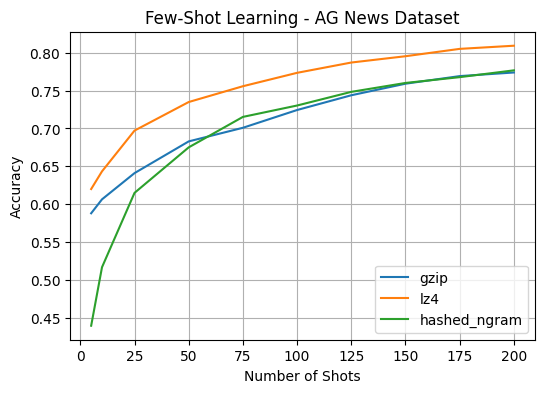

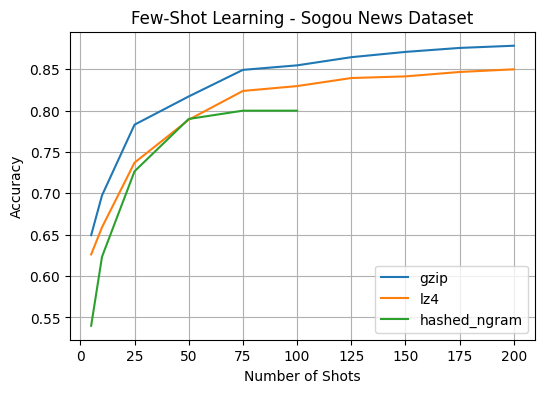

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results, columns=['Dataset', 'Compressor', 'Num_Train', 'Accuracy', 'Time'])

# Separate data for each dataset
df_ag_news = df[df['Dataset'] == 'ag_news']
df_sogou_news = df[df['Dataset'] == 'sogou_news']

# Plotting function
def plot_dataset(dataset_df, title):
    plt.figure(figsize=(6, 4))
    for compressor in dataset_df['Compressor'].unique():
        subset = dataset_df[dataset_df['Compressor'] == compressor]
        plt.plot(subset['Num_Train'], subset['Accuracy'], label=compressor)

    plt.xlabel('Number of Shots')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for ag_news
plot_dataset(df_ag_news, 'Few-Shot Learning - AG News Dataset')

# Plot for sogou_news
plot_dataset(df_sogou_news, 'Few-Shot Learning - Sogou News Dataset')


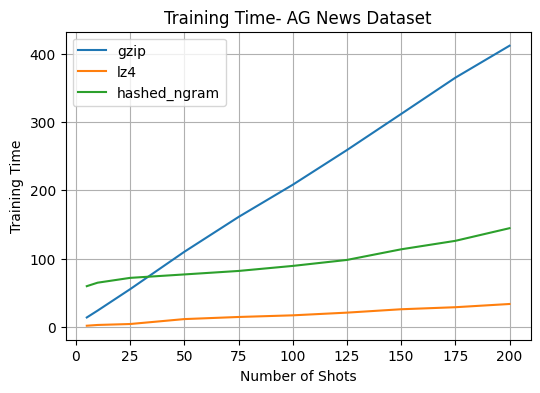

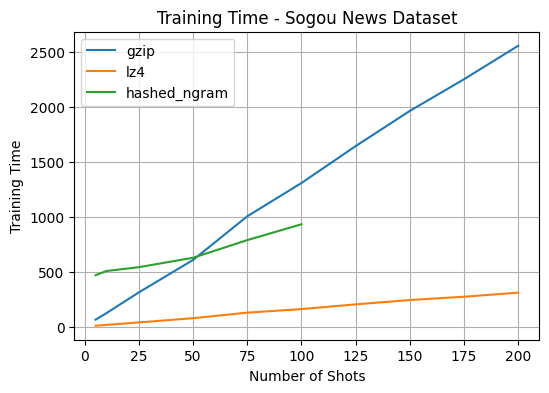

In [ ]:
# Plotting function
def plot_dataset(dataset_df, title):
    plt.figure(figsize=(6, 4))
    for compressor in dataset_df['Compressor'].unique():
        subset = dataset_df[dataset_df['Compressor'] == compressor]
        plt.plot(subset['Num_Train'], subset['Time'], label=compressor)

    plt.xlabel('Number of Shots')
    plt.ylabel('Training Time')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for ag_news
plot_dataset(df_ag_news, 'Training Time- AG News Dataset')

# Plot for sogou_news
plot_dataset(df_sogou_news, 'Training Time - Sogou News Dataset')

# LZ4

In [ ]:
data_dir = 'data'
output_dir = 'text_exp_output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

k = 2
para = True

# Datasets and compressors to iterate over
datasets = ['ag_news', 'sogou_news']
compressor =  'lz4'
num_trains = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

# DataFrame to store results
results = []

# Loop over configurations
for dataset in datasets:

    if dataset == 'ag_news':
      num_test  = 1900
      len_train = 30000
    elif dataset == 'sogou_news':
      num_test  = 12000
      len_train = 90000
    train_idx_fn = os.path.join(output_dir, '{}_train_indicies'.format(dataset))
    test_idx_fn = os.path.join(output_dir, '{}_test_indicies'.format(dataset))

    # Load dataset
    full_dataset = load_dataset(dataset)
    train_dataset = full_dataset['train']
    test_dataset = full_dataset['test']
    test_data, test_labels = pick_n_samples_from_each_class(dataset,test_dataset, num_test, test_idx_fn)

    for num_train in range(400,30001,800):
        accuracies = []
        time_spents = []

        train_data, train_labels = pick_n_samples_from_each_class(dataset,train_dataset, num_train, train_idx_fn)
        acc, time_spent = non_neural_knn_exp(compressor, test_data, test_labels, train_data, train_labels, agg_by_concat_space, NCD, k, para=para)

        # Print current configuration and accuracy
        print(f"Dataset: {dataset}, Compressor: {compressor}, Number of Training Samples: {num_train}, Seed: {seed}, Accuracy: {acc:.2f}, Time Spent: {time_spent:.2f}")

        results.append([dataset, compressor, num_train, acc, time_spent])
    print('Compressor: {compressor} results:')
results

# dataset stats

In [ ]:
from collections import Counter

def calculate_stats(dataset):
    total_length = 0
    word_set = set()

    for entry in dataset:
        # For 'ag_news', use 'text'; for 'sogou_news', concatenate 'title' and 'content'
        text = entry['text'] if 'text' in entry else entry['title'] + ' ' + entry['content']

        words = text.split()
        total_length += len(words)
        word_set.update(words)

    avg_length = total_length / len(dataset)
    vocab_size = len(word_set)

    return avg_length, vocab_size

# Assuming you have a function load_dataset to load your datasets
datasets = ['ag_news', 'sogou_news']

for dataset_name in datasets:
    full_dataset = load_dataset(dataset_name)
    train_dataset = full_dataset['train']
    test_dataset = full_dataset['test']

    train_avg_length, train_vocab_size = calculate_stats(train_dataset)
    test_avg_length, test_vocab_size = calculate_stats(test_dataset)

    print(f"{dataset_name} - Training Set: Avg Length = {train_avg_length}, Vocab Size = {train_vocab_size}")
    print(f"{dataset_name} - Testing Set: Avg Length = {test_avg_length}, Vocab Size = {test_vocab_size}")


Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

ag_news - Training Set: Avg Length = 37.84745, Vocab Size = 188110
ag_news - Testing Set: Avg Length = 37.72236842105263, Vocab Size = 40819
sogou_news - Training Set: Avg Length = 566.4396155555555, Vocab Size = 789057
sogou_news - Testing Set: Avg Length = 569.7002166666666, Vocab Size = 198672


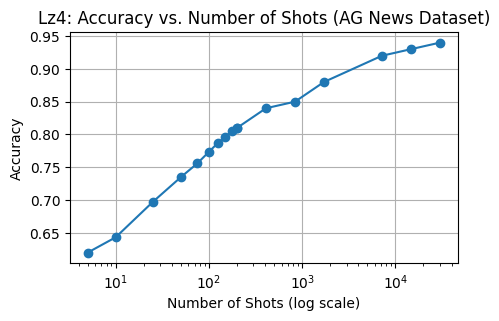

In [1]:
import matplotlib.pyplot as plt
import numpy as np

results_ag_news = [
    ['ag_news', 'lz4', 5, 0.6199444444444444, 1.5638540585835774],
    ['ag_news', 'lz4', 10, 0.6433333333333334, 2.674830754597982],
    ['ag_news', 'lz4', 25, 0.6972222222222223, 4.062642892201741],
    ['ag_news', 'lz4', 50, 0.735, 11.278603235880533],
    ['ag_news', 'lz4', 75, 0.7558888888888889, 14.37153442700704],
    ['ag_news', 'lz4', 100, 0.7736111111111111, 16.78374234835307],
    ['ag_news', 'lz4', 125, 0.7872222222222223, 20.732188145319622],
    ['ag_news', 'lz4', 150, 0.7955555555555556, 25.688343286514282],
    ['ag_news', 'lz4', 175, 0.8052777777777779, 28.665870428085327],
    ['ag_news', 'lz4', 200, 0.8094444444444444, 33.39549311002096],
    ['ag_news', 'lz4', 200, 0.81, 78.97],
    ['ag_news', 'lz4', 409, 0.84, 21.50],
    ['ag_news', 'lz4', 837, 0.85, 44.06],
    ['ag_news', 'lz4', 1712, 0.88, 91.84],
    ['ag_news', 'lz4', 7167, 0.92, 377.55],
    ['ag_news', 'lz4', 14663, 0.93, 777.44],
    ['ag_news', 'lz4', 30000, 0.94, 1573.08]
]

# Extracting the number of shots and accuracy
num_shots = [item[2] for item in results_ag_news]
accuracy = [item[3] for item in results_ag_news]

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(num_shots, accuracy, marker='o')

# Since we want a log scale for the x-axis
plt.xscale('log')

# Labeling the axes
plt.xlabel('Number of Shots (log scale)')
plt.ylabel('Accuracy')

# Adding a title
plt.title('Lz4: Accuracy vs. Number of Shots (AG News Dataset)')

# Display the grid
plt.grid(True)

# Show plot
plt.show()
